In [326]:
# import python packages to use for analysis
import numpy as np
import pandas as pd
import os
import glob
import pprint
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.colors import ListedColormap
import seaborn as sns
from scipy.stats import norm
import ast
Z = norm.ppf

In [327]:
data_dir = ["./data"]

# define empty lists that will hold the number of subjects, rejected subjects and test subjects
sub_count = [0]*len(data_dir)    # included datasets
reject_count = [0]*len(data_dir) # complete datasets, but rejected due to performance
test_count = [0]*len(data_dir)   # incomplete test datasets

complete_subs = [] # subjects that produced complete datasets

prac_n = 16 # number of practice trials
exp_n = 160 # number of experiment trials

all_data = []


for e, cur_dir in enumerate(data_dir):
    file_list = glob.glob(cur_dir + "/object_recognition*.csv")
    file_list.sort()
    exp_subs = [] # list to hold the subjects in this experiment
    for file in file_list:
        # load the data
        try:
            sub_data = pd.read_csv(file)
            if "trial_type" not in sub_data:
                sub_data = pd.read_csv(file, skiprows=1)
            # in the past, some trials were duplicated in the data file, the code below takes care of that
            sub_data = sub_data[sub_data['trial_index'].apply(lambda x: str(x).isdigit())]
            sub_data = sub_data.drop_duplicates()
        except:
            print("Failed to load file {0}".format(file.split(cur_dir)[1]))
        # get id
        try:
            survey_resp = sub_data[sub_data["trial_type"]=="survey-html-form"].loc[0]["response"]
            survey_resp = survey_resp.replace(':"}',':""}')
            sub_info = ast.literal_eval(survey_resp)
        except:
            sub_info = {}
        # see if id was stored
        if 'p_id' in sub_info.keys():  
            sub_id = sub_info["p_id"]
        else:
            sub_id = "nan"
            
        # do quality control on the data
        if sub_data.shape[1] < 10:
            print(e, sub_id, "incomplete file, shape:{0}x{1}".format(sub_data.shape[0],sub_data.shape[1]))
            test_count[e] = test_count[e] + 1 # record test subject to the test_count, by adding 1 at the relevant position
            continue
        
        # now skip if this subjects data is already in the set
        #if sub_id in exp_subs:
        #    continue
        
        # add participant to list of subjects for this experiment
        exp_subs.append(sub_id)
        
        # start populating sub_info dict: 
        sub_info["experiment"] = e
        sub_info["ID"] = sub_id
        
        # get data from file
        images = sub_data["images"]
        left_choice = sub_data["left_choice"]
        right_choice = sub_data["right_choice"]
        rts = sub_data["rt"]
        response = sub_data["button_pressed"] # 0 = left; 1 = right;
        valid_loc = [ ~np.isnan(x) for x in images ]
        valid_images = [ int(x) for i, x in enumerate(images) if valid_loc[i] ] # image number
        valid_left = [ int(x) for i, x in enumerate(left_choice) if valid_loc[i] ] # which object appeared as left choice
        valid_right = [ int(x) for i, x in enumerate(right_choice) if valid_loc[i] ]
        valid_response = [ int(response[i+1]) for i, x in enumerate(response) if valid_loc[i] ] # which side did the subject choose
        choices = [ [l, r] for l, r in zip(valid_left, valid_right) ]
        valid_rt = [ float(rts[i+1]) for i, x in enumerate(rts) if valid_loc[i] ] # reaction time
        
        correct_obj_no = np.tile(range(10),[20,1])
        correct_obj_no = correct_obj_no.flatten("F") # corresponding correct object number per image
        correct_choice = [ correct_obj_no[x] for x in valid_images ]
        
        ##  compile the data table that will be used in future analysis

        num_trials = sum(valid_loc) # total trials
        
        # lets fetch all the relevant trial variables for each trial
        sub_info["im_no"] = valid_images; # all image numbers
        sub_info["target"] = correct_choice; # what was the target object number?            
        sub_info["distractor"] = [ int(np.array(i) [i != j ]) for i, j in zip(choices, correct_choice) ] # what was the distractor object number?
        sub_info["response"] = [ i [j] for i, j in zip(choices, valid_response) ] # which object with the subject choose?
        sub_info["correct"] = [i == j for i, j in zip(sub_info["response"], sub_info["target"])]
        sub_info["rt"] = valid_rt
        
        unique_objects = np.unique(correct_obj_no) # unique object numbers
        num_objects = len(unique_objects);      # how many objects are there?
        
        sub_conf = np.empty((num_objects, num_objects))
        sub_conf[:] = np.nan
        
        for i in unique_objects:
            for j in unique_objects:
                cur_idx = [t == i and d == j for t,d in zip(sub_info["target"], sub_info["distractor"])]
                if np.sum(cur_idx) > 0:
                    sub_conf[i,j] = 1 - np.nanmean(np.array(sub_info["correct"])[cur_idx])
        sub_info["conf"] = sub_conf
        all_data.append(sub_info)
        


In [350]:
all_conf = np.array([x["conf"] for x in all_data ])
mean_conf = np.nanmean(all_conf, 0)
all_corr = np.array([np.mean(x["correct"]) for x in all_data ])
mean_corr = np.nanmean(all_corr)
print(all_corr)


[0.90954774 0.91457286 0.86432161 0.79899497 0.91959799 0.94974874
 0.86934673 0.94472362 0.88944724 0.86432161 0.88944724 0.63316583]


/Users/kohler/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: Mean of empty slice
  


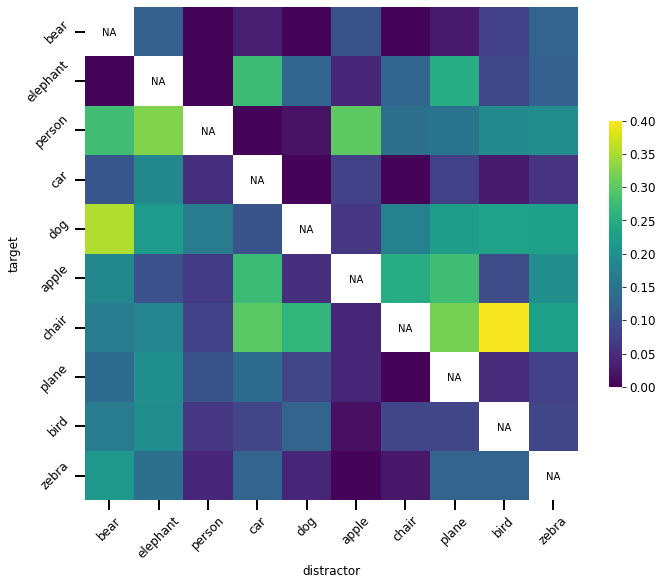

In [345]:
## plot confusion matrix
labels = ['bear','elephant','person','car','dog','apple','chair','plane','bird','zebra']
conf_df = pd.DataFrame(mean_conf, columns = labels, index = labels)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,10))
font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 12}
plt.rc('font', **font)
sns.heatmap(
    np.where(conf_df.isna(), 0, np.nan),
    ax=ax,
    cbar=False,
    annot=np.full_like(conf_df, "NA", dtype=object),
    fmt="",
    annot_kws={"size": 10, "va": "center_baseline", "color": "black"},
    cmap=ListedColormap(['none']),
    linewidth=0)
sns.heatmap(
    conf_df, 
    ax=ax, 
    vmin=0, vmax=.4, 
    cbar=True, cbar_kws={'shrink':.4}, 
    cmap=sns.color_palette("viridis", 100), 
    square=True) 

ax.set_xticklabels(labels, rotation = 45, ha="center")
plt.xlabel("distractor")
plt.ylabel("target")
ax.set_yticklabels(labels, rotation = 45, va="center")
ax.tick_params(length=10, width=2)
plt.tight_layout()